## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
from datetime import datetime

DEVICE_NAME = 'cuda:1'

now = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
model_name = f'gru_attention_beam_search_{now}'

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_to_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_to_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_to_data = './data.txt'

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchtext
from torchtext.data import Field, BucketIterator
from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from tqdm import tqdm
import time
import random

import matplotlib.pyplot as plt
%matplotlib inline

from utils import generate_translation, remove_tech_tokens, get_text, \
                    parse_tensorboard_logs, plot_metrics, beam_search, _len_sort_key, init_weights, count_parameters

In [4]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05], random_state=random.seed(SEED))

In [8]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [9]:
SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)

In [10]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9256
Unique tokens in target (en) vocabulary: 6734


Here are tokens from original (RU) corpus:

In [11]:
SRC.vocab.itos[::1000]

['<unk>',
 'террасу',
 'чистые',
 'компьютеры',
 'don',
 'шамони',
 'logis',
 'форму',
 'душевые',
 'техасского']

And from target (EN) corpus:

In [12]:
TRG.vocab.itos[::1000]

['<unk>', 'springs', 'galeao', 'calm', 'occupies', 'tegel', 'malioboro']

And here is example from train dataset:

In [13]:
idx = 9
print(' '.join(train_data.examples[idx].src))
print(' '.join(train_data.examples[idx].trg))

также предлагается доставка продуктов , услуги прачечной и гладильные услуги .
other facilities offered at the property include grocery deliveries , laundry and ironing services .


Let's check the length distributions:

In [14]:
def plt_len_dist(data, name):
    src_length = list(map(len, [x.src for x in data.examples]))
    trg_length = list(map(len, [x.trg for x in data.examples]))

    print(f'Length distribution in {name} data')
    print(f'Max source length: {max(src_length)}')
    print(f'Max target length: {max(trg_length)}')
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.title("source length")
    plt.hist(list(src_length), bins=20);

    plt.subplot(1, 2, 2)
    plt.title("translation length")
    plt.hist(list(trg_length), bins=20)

Length distribution in Train data
Max source length: 73
Max target length: 89


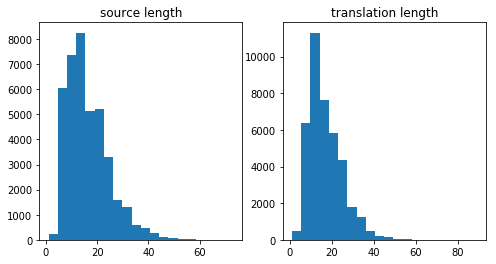

In [15]:
plt_len_dist(train_data, 'Train')

Length distribution in Validation data
Max source length: 76
Max target length: 73


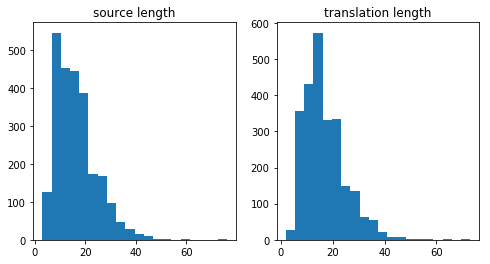

In [16]:
plt_len_dist(valid_data, 'Validation')

Length distribution in Test data
Max source length: 80
Max target length: 99


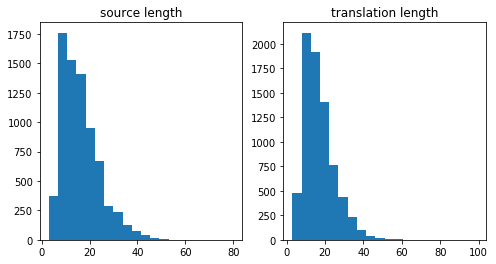

In [17]:
plt_len_dist(test_data, 'Test')

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [18]:
device = torch.device(DEVICE_NAME if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [19]:
def eval_bleu(model, test_iterator, target_vocab=TRG.vocab, beam_width=1, with_tqdm=True):
    assert beam_width > 0
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():
        if with_tqdm:
            test_iterator = tqdm(test_iterator, position=0, leave=True)
        for i, batch in enumerate(test_iterator):
            src = batch.src # [src sent len, batch size]
            trg = batch.trg # [trg sent len, batch size]
            
            if beam_width == 1:
                output = model(src, trg, 0) #turn off teacher forcing
                #output = [trg sent len, batch size, output dim]

                output = output.argmax(dim=-1) # [trg sent len, batch size]
            else:
                output = beam_search(model, src, trg, target_vocab, beam_width)  # [trg sent len, batch size]

            original_text.extend([get_text(x, target_vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, target_vocab) for x in output[1:].detach().cpu().numpy().T])
    return corpus_bleu([[text] for text in original_text], generated_text) * 100

In [20]:
def get_teacher_forcing_ratio(epoch, base_teacher_forcing_ratio=0.5, decay=1):
    return base_teacher_forcing_ratio * decay ** epoch

In [21]:
def train(model, iterator, optimizer, criterion, clip, epoch):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):        
        src = batch.src # [src sent len, batch size]
        trg = batch.trg # [trg sent len, batch size]
        
        optimizer.zero_grad()        
        teacher_forcing_ratio = get_teacher_forcing_ratio(epoch)
        output = model(src, trg, teacher_forcing_ratio) # [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size, output dim]
        trg = trg[1:].view(-1) # [(trg sent len - 1) * batch size]
        
        loss = criterion(output, trg)        
        loss.backward()
        
        # Let's clip the gradient
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()        
        batch_loss = loss.item()
        epoch_loss += batch_loss
        
    return epoch_loss / len(iterator)

In [22]:
def evaluate(model, iterator, criterion):    
    model.eval()    
    epoch_loss = 0    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            src = batch.src # [src sent len, batch size]
            trg = batch.trg # [trg sent len, batch size]

            output = model(src, trg, 0) #turn off teacher forcing
            # [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size]
            trg = trg[1:].view(-1) # [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
def training_procedure(model, model_name, train_iterator, valid_iterator,
                      optimizer, lr_scheduler, criterion, writer, clip, n_epochs, beam_width=10):
    best_valid_bleu = float('-inf')
    for epoch in tqdm(range(n_epochs)):    
        start_time = time.time()

        train_loss = train(model, train_iterator, optimizer, criterion, clip, epoch)
        valid_loss = evaluate(model, valid_iterator, criterion)
        lr_scheduler.step(valid_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        valid_bleu_greedy = eval_bleu(model, valid_iterator, beam_width=1, with_tqdm=False)
        writer.add_scalar('Validation BLEU (Greedy)',
                    valid_bleu_greedy,
                    epoch)
        
        if beam_width is None:
            valid_bleu_beam = float('-inf')
        else:
            valid_bleu_beam = eval_bleu(model, valid_iterator, beam_width=beam_width, with_tqdm=False)
            writer.add_scalar(f'Validation BLEU (BeamSearch@{beam_width})',
                        valid_bleu_beam,
                        epoch)
        
        max_bleu = max(valid_bleu_greedy, valid_bleu_beam)
        if max_bleu > best_valid_bleu:
            best_valid_bleu = max_bleu
            torch.save(model.state_dict(), f'models/{model_name}.pt')

        writer.add_scalar('Train loss',
                    train_loss,
                    epoch)
        writer.add_scalar('Validation loss',
                    valid_loss,
                    epoch)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')
        if beam_width is None:
            print(f'\tVal. BLEU (Greedy): {valid_bleu_greedy:.3f}')
        else:
            print(f'\tVal. BLEU (Greedy): {valid_bleu_greedy:.3f} | Val. BLEU (BeamSearch@{beam_width}): {valid_bleu_beam:.3f}')

In [25]:
def get_tensorboard_dir(model_name):
    return f'runs/{model_name}'

In [26]:
def print_samples(model, test_iterator, indices=range(0, 10), beam_widths=[2,10]):
    batch = next(iter(test_iterator))
    for idx in indices:
        src = batch.src[:, idx:idx+1]
        trg = batch.trg[:, idx:idx+1]
        generate_translation(src, trg, model, TRG.vocab, beam_widths)

## Let's use GRU encoder-decoder with attention

In [27]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [28]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
BIDIRECTIONAL = False

LR = 1e-3
CLIP = 1
N_EPOCHS = 40

In [29]:
from models import GruEncoder, AttentionGruDecoder, AttentionGruSeq2Seq

enc = GruEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, BIDIRECTIONAL, ENC_DROPOUT)
dec = AttentionGruDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = AttentionGruSeq2Seq(enc, dec, device).to(device)
model.apply(init_weights)

AttentionGruSeq2Seq(
  (encoder): GruEncoder(
    (embedding): Embedding(9256, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttentionGruDecoder(
    (embedding): Embedding(6734, 256)
    (attention): Attention(
      (linear_in): Linear(in_features=1024, out_features=1024, bias=False)
      (linear_out): Linear(in_features=2048, out_features=1024, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=1024, out_features=6734, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (state_mapper): Linear(in_features=1024, out_features=1024, bias=True)
  (context_mapper): Linear(in_features=512, out_features=1024, bias=True)
)

In [30]:
count_parameters(model)

21233742

In [31]:
PAD_IDX = TRG.vocab.stoi['<pad>']

In [32]:
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.001, amsgrad=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [33]:
tensorboard_dir = get_tensorboard_dir(model_name)
print(tensorboard_dir)
writer = SummaryWriter(tensorboard_dir)
training_procedure(model, model_name, train_iterator, valid_iterator,
                      optimizer, lr_scheduler, criterion, writer, clip=CLIP, n_epochs=N_EPOCHS)

  0%|          | 0/40 [00:00<?, ?it/s]

runs/gru_attention_beam_search_2020-05-30--01-10-20


  2%|▎         | 1/40 [04:10<2:42:53, 250.60s/it]

Epoch: 01 | Time: 1m 53s
	Train Loss: 4.267 | Train PPL:  71.329
	 Val. Loss: 4.670 |  Val. PPL: 106.712
	Val. BLEU (Greedy): 16.564 | Val. BLEU (BeamSearch@10): 18.394


  5%|▌         | 2/40 [08:12<2:36:59, 247.87s/it]

Epoch: 02 | Time: 1m 53s
	Train Loss: 3.267 | Train PPL:  26.239
	 Val. Loss: 4.684 |  Val. PPL: 108.221
	Val. BLEU (Greedy): 22.898 | Val. BLEU (BeamSearch@10): 24.970


  8%|▊         | 3/40 [12:10<2:31:02, 244.94s/it]

Epoch: 03 | Time: 1m 53s
	Train Loss: 2.968 | Train PPL:  19.445
	 Val. Loss: 4.380 |  Val. PPL:  79.840
	Val. BLEU (Greedy): 25.298 | Val. BLEU (BeamSearch@10): 26.589


 10%|█         | 4/40 [16:17<2:27:25, 245.72s/it]

Epoch: 04 | Time: 1m 53s
	Train Loss: 2.745 | Train PPL:  15.563
	 Val. Loss: 4.513 |  Val. PPL:  91.185
	Val. BLEU (Greedy): 27.194 | Val. BLEU (BeamSearch@10): 29.737


 12%|█▎        | 5/40 [20:25<2:23:44, 246.41s/it]

Epoch: 05 | Time: 1m 54s
	Train Loss: 2.594 | Train PPL:  13.387
	 Val. Loss: 4.434 |  Val. PPL:  84.309
	Val. BLEU (Greedy): 28.435 | Val. BLEU (BeamSearch@10): 31.536


 15%|█▌        | 6/40 [24:30<2:19:21, 245.94s/it]

Epoch: 06 | Time: 1m 54s
	Train Loss: 2.491 | Train PPL:  12.078
	 Val. Loss: 4.294 |  Val. PPL:  73.273
	Val. BLEU (Greedy): 27.612 | Val. BLEU (BeamSearch@10): 30.500


 18%|█▊        | 7/40 [28:30<2:14:14, 244.09s/it]

Epoch: 07 | Time: 1m 51s
	Train Loss: 2.394 | Train PPL:  10.958
	 Val. Loss: 4.336 |  Val. PPL:  76.380
	Val. BLEU (Greedy): 29.986 | Val. BLEU (BeamSearch@10): 32.515


 20%|██        | 8/40 [32:32<2:09:56, 243.63s/it]

Epoch: 08 | Time: 1m 51s
	Train Loss: 2.280 | Train PPL:   9.780
	 Val. Loss: 4.426 |  Val. PPL:  83.589
	Val. BLEU (Greedy): 30.379 | Val. BLEU (BeamSearch@10): 33.139


 22%|██▎       | 9/40 [36:32<2:05:15, 242.43s/it]

Epoch: 09 | Time: 1m 52s
	Train Loss: 2.179 | Train PPL:   8.835
	 Val. Loss: 4.384 |  Val. PPL:  80.167
	Val. BLEU (Greedy): 29.404 | Val. BLEU (BeamSearch@10): 32.908


 25%|██▌       | 10/40 [40:33<2:00:59, 241.97s/it]

Epoch: 10 | Time: 1m 52s
	Train Loss: 1.935 | Train PPL:   6.924
	 Val. Loss: 4.355 |  Val. PPL:  77.847
	Val. BLEU (Greedy): 33.389 | Val. BLEU (BeamSearch@10): 35.919


 28%|██▊       | 11/40 [44:30<1:56:14, 240.51s/it]

Epoch: 11 | Time: 1m 53s
	Train Loss: 1.837 | Train PPL:   6.279
	 Val. Loss: 4.405 |  Val. PPL:  81.897
	Val. BLEU (Greedy): 32.830 | Val. BLEU (BeamSearch@10): 35.868


 30%|███       | 12/40 [48:25<1:51:31, 238.97s/it]

Epoch: 12 | Time: 1m 53s
	Train Loss: 1.804 | Train PPL:   6.071
	 Val. Loss: 4.394 |  Val. PPL:  80.973
	Val. BLEU (Greedy): 33.330 | Val. BLEU (BeamSearch@10): 36.070


 32%|███▎      | 13/40 [52:23<1:47:24, 238.67s/it]

Epoch: 13 | Time: 1m 53s
	Train Loss: 1.688 | Train PPL:   5.406
	 Val. Loss: 4.343 |  Val. PPL:  76.932
	Val. BLEU (Greedy): 33.700 | Val. BLEU (BeamSearch@10): 36.627


 35%|███▌      | 14/40 [56:21<1:43:16, 238.31s/it]

Epoch: 14 | Time: 1m 54s
	Train Loss: 1.691 | Train PPL:   5.424
	 Val. Loss: 4.366 |  Val. PPL:  78.705
	Val. BLEU (Greedy): 33.884 | Val. BLEU (BeamSearch@10): 36.736


 38%|███▊      | 15/40 [1:00:26<1:40:06, 240.26s/it]

Epoch: 15 | Time: 1m 54s
	Train Loss: 1.674 | Train PPL:   5.335
	 Val. Loss: 4.402 |  Val. PPL:  81.602
	Val. BLEU (Greedy): 33.639 | Val. BLEU (BeamSearch@10): 36.608


 40%|████      | 16/40 [1:04:27<1:36:16, 240.71s/it]

Epoch: 16 | Time: 1m 54s
	Train Loss: 1.639 | Train PPL:   5.148
	 Val. Loss: 4.410 |  Val. PPL:  82.310
	Val. BLEU (Greedy): 33.945 | Val. BLEU (BeamSearch@10): 36.933


 42%|████▎     | 17/40 [1:08:25<1:31:53, 239.73s/it]

Epoch: 17 | Time: 1m 53s
	Train Loss: 1.649 | Train PPL:   5.203
	 Val. Loss: 4.405 |  Val. PPL:  81.861
	Val. BLEU (Greedy): 33.934 | Val. BLEU (BeamSearch@10): 36.928


 45%|████▌     | 18/40 [1:12:24<1:27:48, 239.47s/it]

Epoch: 18 | Time: 1m 52s
	Train Loss: 1.637 | Train PPL:   5.137
	 Val. Loss: 4.405 |  Val. PPL:  81.850
	Val. BLEU (Greedy): 33.876 | Val. BLEU (BeamSearch@10): 36.921


 48%|████▊     | 19/40 [1:16:22<1:23:41, 239.13s/it]

Epoch: 19 | Time: 1m 52s
	Train Loss: 1.636 | Train PPL:   5.135
	 Val. Loss: 4.399 |  Val. PPL:  81.384
	Val. BLEU (Greedy): 33.823 | Val. BLEU (BeamSearch@10): 37.024


 50%|█████     | 20/40 [1:20:12<1:18:48, 236.41s/it]

Epoch: 20 | Time: 1m 51s
	Train Loss: 1.616 | Train PPL:   5.034
	 Val. Loss: 4.414 |  Val. PPL:  82.574
	Val. BLEU (Greedy): 33.828 | Val. BLEU (BeamSearch@10): 36.967


 52%|█████▎    | 21/40 [1:24:08<1:14:46, 236.14s/it]

Epoch: 21 | Time: 1m 52s
	Train Loss: 1.619 | Train PPL:   5.046
	 Val. Loss: 4.427 |  Val. PPL:  83.670
	Val. BLEU (Greedy): 33.910 | Val. BLEU (BeamSearch@10): 36.987


 55%|█████▌    | 22/40 [1:28:13<1:11:40, 238.93s/it]

Epoch: 22 | Time: 1m 54s
	Train Loss: 1.641 | Train PPL:   5.160
	 Val. Loss: 4.414 |  Val. PPL:  82.589
	Val. BLEU (Greedy): 33.838 | Val. BLEU (BeamSearch@10): 36.995


 57%|█████▊    | 23/40 [1:32:16<1:08:03, 240.20s/it]

Epoch: 23 | Time: 1m 51s
	Train Loss: 1.599 | Train PPL:   4.946
	 Val. Loss: 4.418 |  Val. PPL:  82.943
	Val. BLEU (Greedy): 33.909 | Val. BLEU (BeamSearch@10): 37.040


 60%|██████    | 24/40 [1:36:19<1:04:15, 240.94s/it]

Epoch: 24 | Time: 1m 52s
	Train Loss: 1.621 | Train PPL:   5.061
	 Val. Loss: 4.421 |  Val. PPL:  83.215
	Val. BLEU (Greedy): 33.923 | Val. BLEU (BeamSearch@10): 37.042


 62%|██████▎   | 25/40 [1:40:17<59:59, 239.98s/it]  

Epoch: 25 | Time: 1m 52s
	Train Loss: 1.635 | Train PPL:   5.131
	 Val. Loss: 4.422 |  Val. PPL:  83.243
	Val. BLEU (Greedy): 33.877 | Val. BLEU (BeamSearch@10): 37.016


 65%|██████▌   | 26/40 [1:44:09<55:29, 237.80s/it]

Epoch: 26 | Time: 1m 51s
	Train Loss: 1.656 | Train PPL:   5.240
	 Val. Loss: 4.426 |  Val. PPL:  83.625
	Val. BLEU (Greedy): 33.875 | Val. BLEU (BeamSearch@10): 37.016


 68%|██████▊   | 27/40 [1:48:13<51:53, 239.50s/it]

Epoch: 27 | Time: 1m 54s
	Train Loss: 1.607 | Train PPL:   4.986
	 Val. Loss: 4.425 |  Val. PPL:  83.487
	Val. BLEU (Greedy): 33.817 | Val. BLEU (BeamSearch@10): 37.025


 70%|███████   | 28/40 [1:52:07<47:33, 237.78s/it]

Epoch: 28 | Time: 1m 54s
	Train Loss: 1.616 | Train PPL:   5.035
	 Val. Loss: 4.425 |  Val. PPL:  83.553
	Val. BLEU (Greedy): 33.806 | Val. BLEU (BeamSearch@10): 37.022


 72%|███████▎  | 29/40 [1:55:58<43:14, 235.88s/it]

Epoch: 29 | Time: 1m 52s
	Train Loss: 1.614 | Train PPL:   5.023
	 Val. Loss: 4.426 |  Val. PPL:  83.561
	Val. BLEU (Greedy): 33.805 | Val. BLEU (BeamSearch@10): 37.070


 75%|███████▌  | 30/40 [1:59:46<38:53, 233.37s/it]

Epoch: 30 | Time: 1m 52s
	Train Loss: 1.619 | Train PPL:   5.049
	 Val. Loss: 4.425 |  Val. PPL:  83.554
	Val. BLEU (Greedy): 33.819 | Val. BLEU (BeamSearch@10): 37.040


 78%|███████▊  | 31/40 [2:03:41<35:06, 234.01s/it]

Epoch: 31 | Time: 1m 53s
	Train Loss: 1.644 | Train PPL:   5.176
	 Val. Loss: 4.425 |  Val. PPL:  83.540
	Val. BLEU (Greedy): 33.818 | Val. BLEU (BeamSearch@10): 37.026


 80%|████████  | 32/40 [2:07:45<31:35, 236.94s/it]

Epoch: 32 | Time: 1m 52s
	Train Loss: 1.641 | Train PPL:   5.159
	 Val. Loss: 4.427 |  Val. PPL:  83.689
	Val. BLEU (Greedy): 33.841 | Val. BLEU (BeamSearch@10): 37.041


 82%|████████▎ | 33/40 [2:11:46<27:47, 238.28s/it]

Epoch: 33 | Time: 1m 53s
	Train Loss: 1.608 | Train PPL:   4.991
	 Val. Loss: 4.427 |  Val. PPL:  83.670
	Val. BLEU (Greedy): 33.836 | Val. BLEU (BeamSearch@10): 36.998


 85%|████████▌ | 34/40 [2:15:47<23:54, 239.04s/it]

Epoch: 34 | Time: 1m 52s
	Train Loss: 1.632 | Train PPL:   5.114
	 Val. Loss: 4.427 |  Val. PPL:  83.712
	Val. BLEU (Greedy): 33.834 | Val. BLEU (BeamSearch@10): 36.993


 88%|████████▊ | 35/40 [2:19:39<19:44, 236.81s/it]

Epoch: 35 | Time: 1m 52s
	Train Loss: 1.614 | Train PPL:   5.024
	 Val. Loss: 4.427 |  Val. PPL:  83.711
	Val. BLEU (Greedy): 33.834 | Val. BLEU (BeamSearch@10): 36.993


 90%|█████████ | 36/40 [2:23:27<15:37, 234.40s/it]

Epoch: 36 | Time: 1m 52s
	Train Loss: 1.630 | Train PPL:   5.102
	 Val. Loss: 4.427 |  Val. PPL:  83.720
	Val. BLEU (Greedy): 33.836 | Val. BLEU (BeamSearch@10): 37.023


 92%|█████████▎| 37/40 [2:27:20<11:41, 233.71s/it]

Epoch: 37 | Time: 1m 52s
	Train Loss: 1.624 | Train PPL:   5.075
	 Val. Loss: 4.427 |  Val. PPL:  83.720
	Val. BLEU (Greedy): 33.836 | Val. BLEU (BeamSearch@10): 37.023


 95%|█████████▌| 38/40 [2:31:12<07:46, 233.38s/it]

Epoch: 38 | Time: 1m 52s
	Train Loss: 1.627 | Train PPL:   5.091
	 Val. Loss: 4.427 |  Val. PPL:  83.719
	Val. BLEU (Greedy): 33.836 | Val. BLEU (BeamSearch@10): 37.024


 98%|█████████▊| 39/40 [2:35:03<03:52, 232.59s/it]

Epoch: 39 | Time: 1m 51s
	Train Loss: 1.614 | Train PPL:   5.024
	 Val. Loss: 4.427 |  Val. PPL:  83.719
	Val. BLEU (Greedy): 33.836 | Val. BLEU (BeamSearch@10): 37.023


100%|██████████| 40/40 [2:38:50<00:00, 231.07s/it]

Epoch: 40 | Time: 1m 50s
	Train Loss: 1.637 | Train PPL:   5.140
	 Val. Loss: 4.427 |  Val. PPL:  83.719
	Val. BLEU (Greedy): 33.836 | Val. BLEU (BeamSearch@10): 37.024


**Let's load best model**

In [34]:
with open(f'models/{model_name}.pt', 'rb') as fp:
    best_state_dict = torch.load(fp, map_location='cpu')
    model.load_state_dict(best_state_dict)

**And look at its predictions**

In [35]:
print_samples(model, test_iterator)

Original:                   there is a 24 - hour front desk at the property .
Generated (Greedy):         the reception is open 24 hours a day .
Generated (BeamSearch@2):   there is a 24 - hour front desk at the property .
Generated (BeamSearch@10):  there is a 24 - hour front desk at the property .

Original:                   you will find a 24 - hour front desk at the property .
Generated (Greedy):         the reception is open 24 hours a day .
Generated (BeamSearch@2):   there is a 24 - hour front desk at the property .
Generated (BeamSearch@10):  there is a 24 - hour front desk at the property .

Original:                   there is a 24 - hour front desk at the property .
Generated (Greedy):         the reception is open 24 hours a day .
Generated (BeamSearch@2):   there is a 24 - hour front desk at the property .
Generated (BeamSearch@10):  there is a 24 - hour front desk at the property .

Original:                   free private parking is available .
Generated (Greedy):      

In [36]:
print('Test BLEU (Greedy):', eval_bleu(model, test_iterator, beam_width=1))

100%|██████████| 59/59 [00:04<00:00,  7.48it/s]


Test BLEU (Greedy): 33.19444257202133


In [37]:
print('Test BLEU (BeamSearch@2):', eval_bleu(model, test_iterator, beam_width=2))

100%|██████████| 59/59 [05:06<00:00,  9.17s/it]


Test BLEU (BeamSearch@2): 34.99724267237638


In [38]:
print('Test BLEU (BeamSearch@5):', eval_bleu(model, test_iterator, beam_width=5))

100%|██████████| 59/59 [05:27<00:00,  9.55s/it]


Test BLEU (BeamSearch@5): 36.15249771081402


In [39]:
print('Test BLEU (BeamSearch@10):', eval_bleu(model, test_iterator, beam_width=10))

100%|██████████| 59/59 [05:55<00:00, 10.94s/it]


Test BLEU (BeamSearch@10): 36.44342587233784


In [40]:
print('Test BLEU (BeamSearch@16):', eval_bleu(model, test_iterator, beam_width=16))

100%|██████████| 59/59 [06:32<00:00, 11.66s/it]


Test BLEU (BeamSearch@16): 36.39802783864351


In [41]:
print('Test BLEU (BeamSearch@32):', eval_bleu(model, test_iterator, beam_width=32))

100%|██████████| 59/59 [07:57<00:00, 14.41s/it]


Test BLEU (BeamSearch@32): 35.25026842489124


**And plot train/val metrics**

In [42]:
logs = parse_tensorboard_logs(tensorboard_dir)

In [43]:
printable_model_name = '_'.join(model_name.split('_')[:-1])

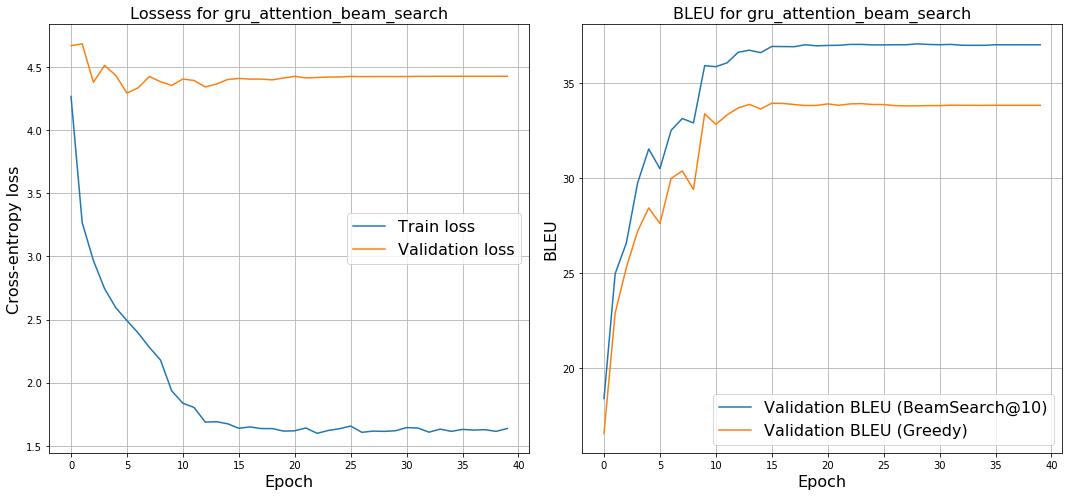

In [44]:
plot_metrics(logs, printable_model_name)